In [1]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

# Summarize baseline results into Pandas DataFrame

In [2]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)

    return model_meta

In [9]:
model_meta = pd.DataFrame()

root_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'film',
                        'fixed_batch_size',
                        'fixed_valid_set',
                        'film_layer1_bn3')
base_dir = root_dir
source_train_baseline_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                                         'film', 
                                         'fixed_batch_size',
                                         'variable_valid_set',
                                         'film_layer1_bn3',
                                         'film_s_20k_t_20')
exp_dir = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]


for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet') and f.startswith('source'):
        trial_results = summarize(os.path.join(root_dir, source_train_baseline_dir), f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx

        try:
            with open(os.path.join(root_dir, source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in exp_dir:
    for f in os.listdir(os.path.join(root_dir, d)):
        if (f.endswith('.parquet')) and ('target' in f):
            trial_results = summarize(os.path.join(root_dir, d), f)
            phase, _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'phase'] = phase
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(root_dir, d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                        'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

# Summarize performance for trained models

In [10]:
source_meta = model_meta[model_meta['phase'] == 'source']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [11]:
source_meta.mean()[performance_cols]

mimic_test_loss       0.607539
mimic_test_acc        0.771956
mimic_test_auc        0.844477
chexpert_test_loss    0.568615
chexpert_test_acc     0.865000
chexpert_test_auc     0.918274
dtype: float64

In [13]:
target_meta = model_meta[model_meta['phase'] == 'target']

performance_cols = ['mimic_best_test_loss', 'mimic_final_test_loss', 'mimic_best_test_acc', 'mimic_final_test_acc',
                    'chexpert_best_test_loss', 'chexpert_final_test_loss', 'chexpert_best_test_acc', 'chexpert_final_test_acc']

In [14]:
target_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                            0.617499               0.617112   
50                            0.616441               0.616391   
100                           0.616072               0.616476   
200                           0.617208               0.616492   
500                           0.617878               0.616904   
1000                          0.617502               0.618196   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                           0.767486              0.773001   
50                           0.770995              0.771121   
100                          0.775006              0.776009   
200                          0.784783              0.779769   
500                          0.777262              0.777262   
1000                         0.782527              0.777137   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                               0.591041                  0.587934   
50                               0.588868                  0.589719   
100                              0.585542                  0.586241   
200                              0.576660                  0.579910   
500                              0.579984                  0.579984   
1000                             0.576820                  0.580325   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                              0.829000                 0.816125  
50                              0.827625                 0.826750  
100                             0.834875                 0.835125  
200                             0.835000                 0.825625  
500                             0.826500                 0.824250  
1000                            0.829250                 0.825750

In [15]:
target_meta.groupby('n_target_samples').mean()[performance_cols]

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                            0.612116               0.611859   
50                            0.612688               0.612814   
100                           0.611382               0.611504   
200                           0.611595               0.611167   
500                           0.611592               0.611503   
1000                          0.612399               0.612300   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                           0.763642              0.763266   
50                           0.765898              0.765229   
100                          0.768906              0.768823   
200                          0.774045              0.770536   
500                          0.770995              0.770285   
1000                         0.772583              0.770870   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                               0.581191                  0.582964   
50                               0.581578                  0.581858   
100                              0.578674                  0.579118   
200                              0.574605                  0.577651   
500                              0.577145                  0.577700   
1000                             0.576107                  0.577372   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                              0.803458                 0.796375  
50                              0.802417                 0.801583  
100                             0.813333                 0.811375  
200                             0.828625                 0.816292  
500                             0.817542                 0.814958  
1000                            0.822542                 0.817750

In [16]:
target_meta.groupby('n_target_samples').std()[performance_cols]

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                            0.005439               0.005447   
50                            0.006159               0.006173   
100                           0.005674               0.005899   
200                           0.006740               0.006078   
500                           0.006668               0.006289   
1000                          0.006364               0.006984   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                           0.005022              0.009973   
50                           0.006136              0.006228   
100                          0.006274              0.007337   
200                          0.010655              0.009679   
500                          0.006824              0.008224   
1000                         0.009902              0.007475   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                               0.008632                  0.005196   
50                               0.006745                  0.007157   
100                              0.006135                  0.006481   
200                              0.002178                  0.002185   
500                              0.002525                  0.002218   
1000                             0.001033                  0.002572   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                              0.034759                 0.019813  
50                              0.028019                 0.029496  
100                             0.026583                 0.027664  
200                             0.006639                 0.010693  
500                             0.013308                 0.011391  
1000                            0.006750                 0.013106

In [18]:
mimic_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_final_test_loss', 'mimic_final_test_acc', 'mimic_final_test_auc'])
chex_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_final_test_loss', 'chexpert_final_test_acc', 'chexpert_final_test_auc'])

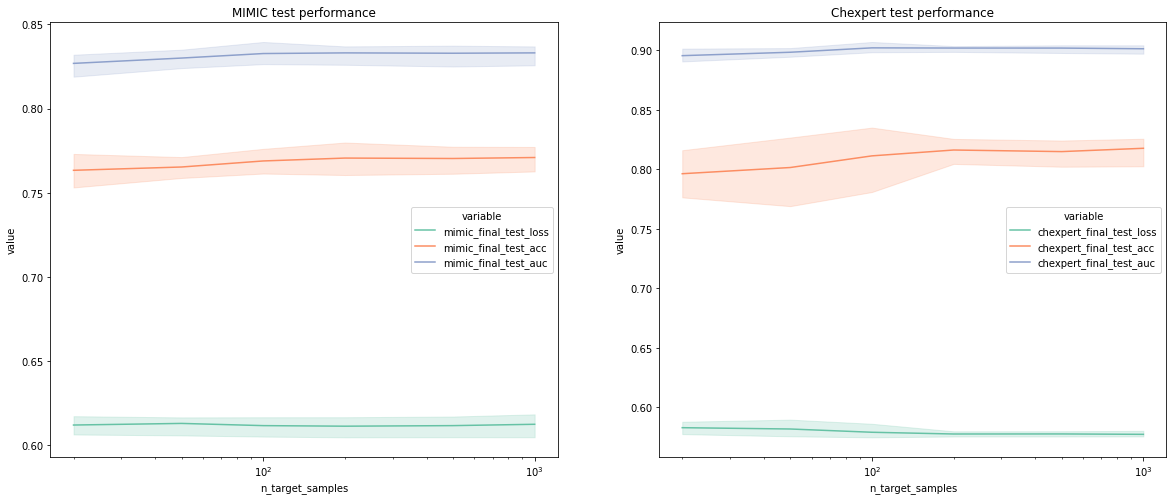

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
ax[0].set(xscale='log')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')
ax[1].set(xscale='log');

# Visualize training and validation losses for the two training phases

In [20]:
def plot_losses(df, phase='target', n_target_samples=20, loss_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{loss_type}_loss'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    losses = np.stack(stackable)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='upper right')

    ax.set_title(f'{loss_type} loss on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('BCE loss')


## 20 MIMIC samples

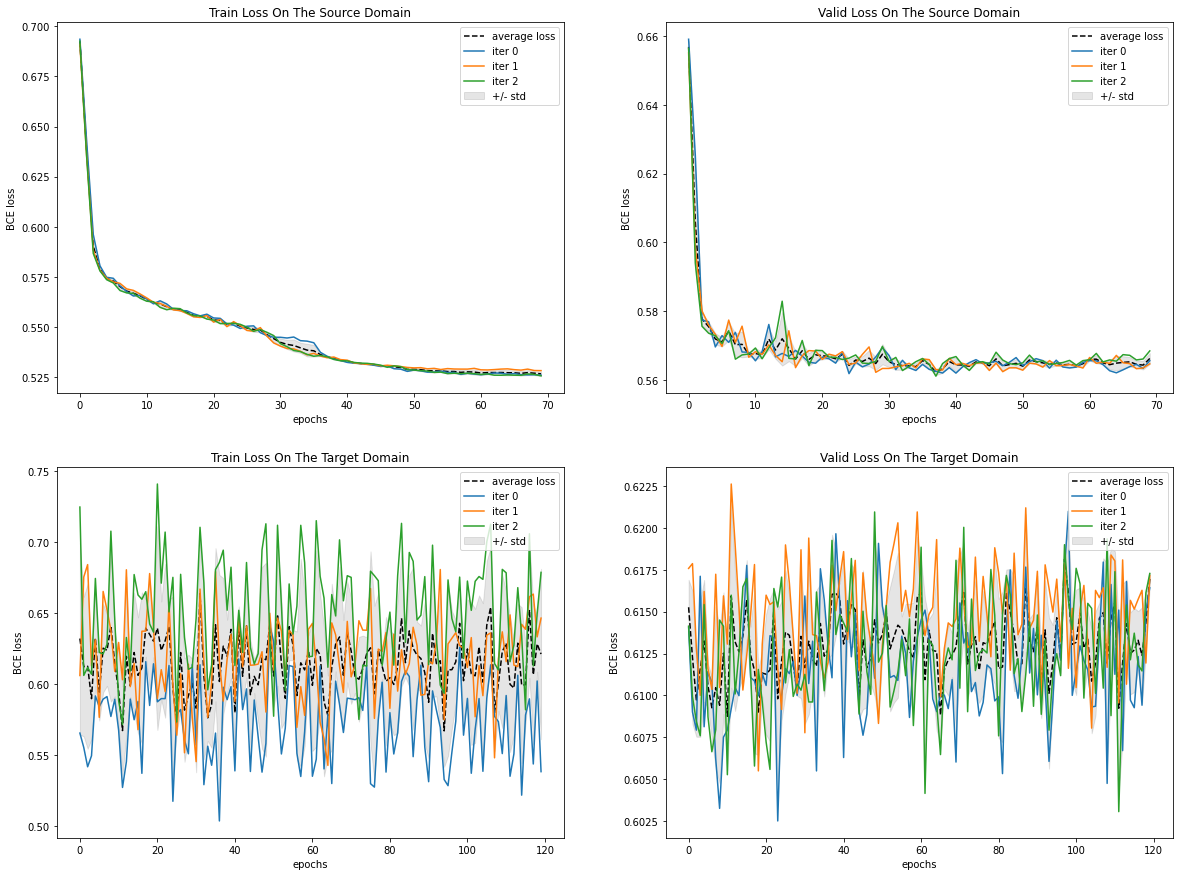

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

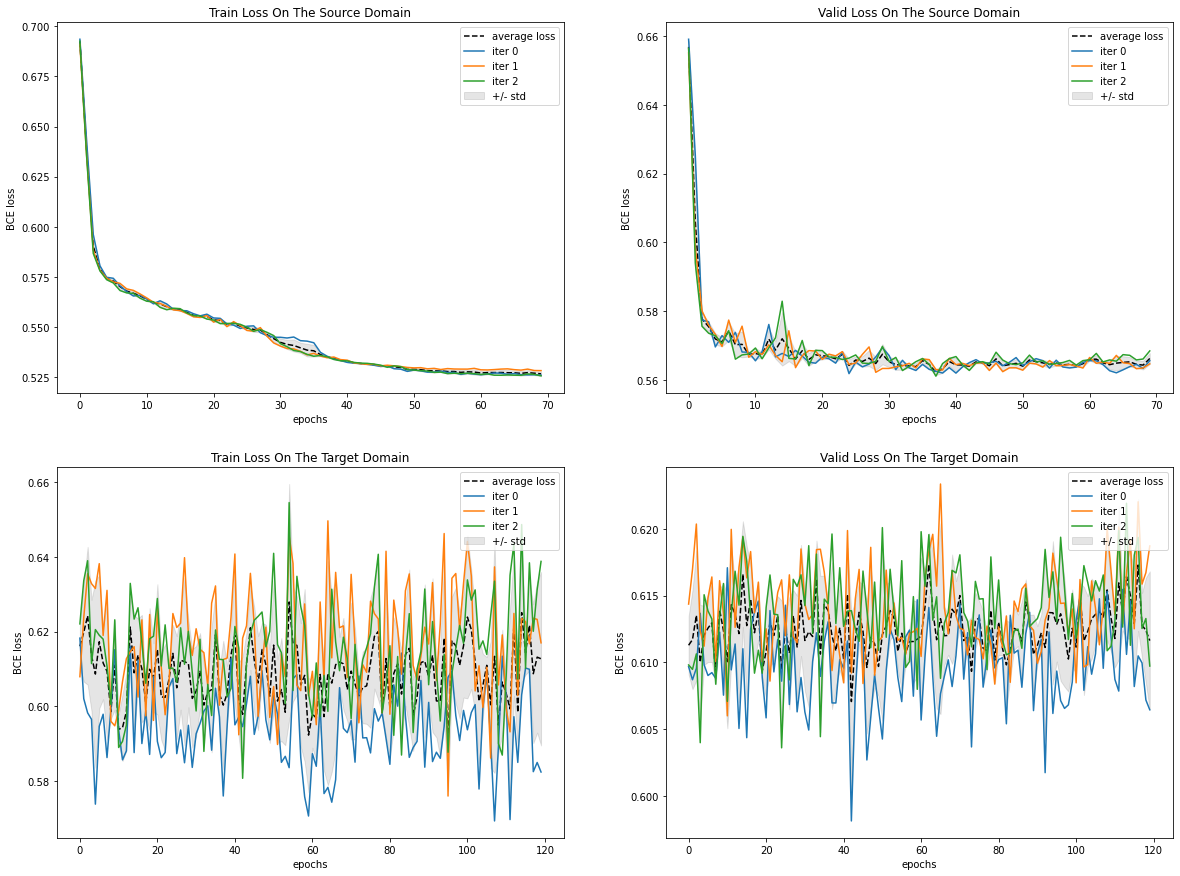

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

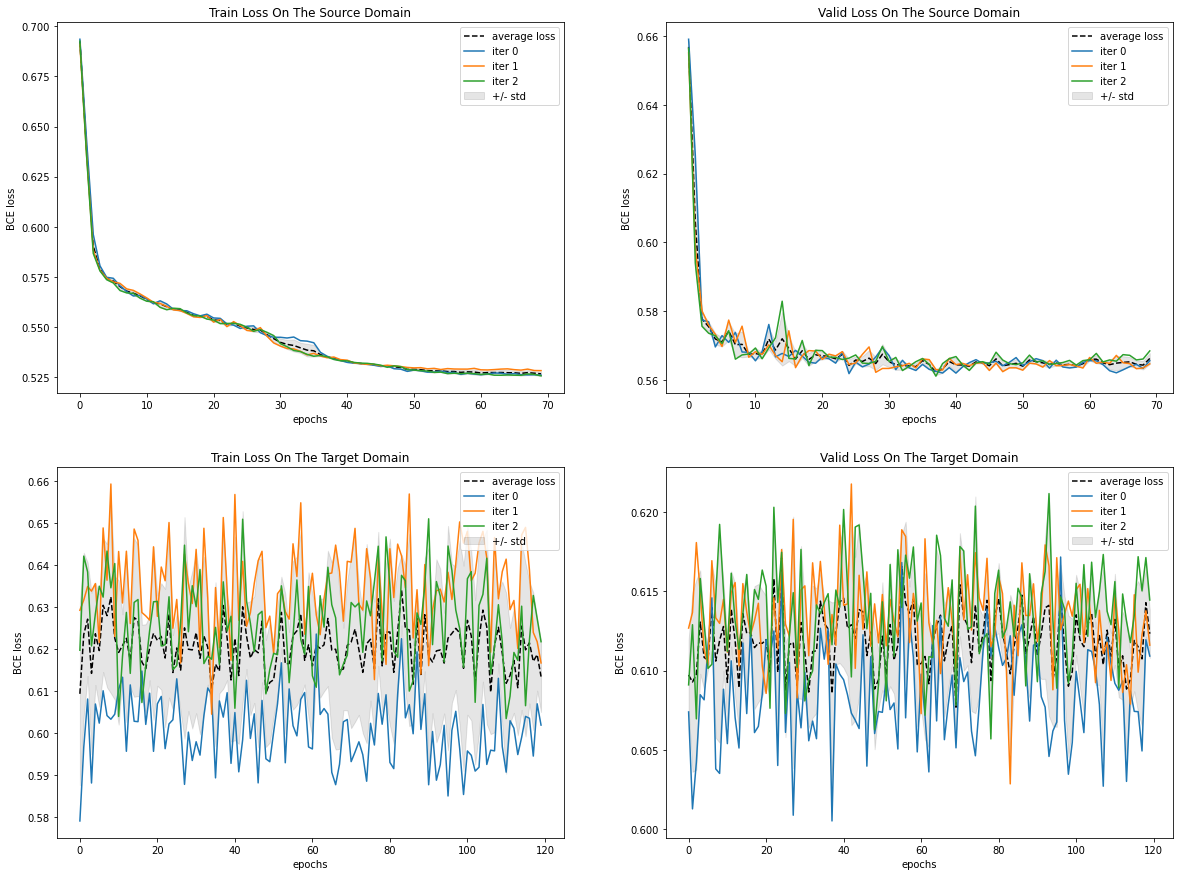

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

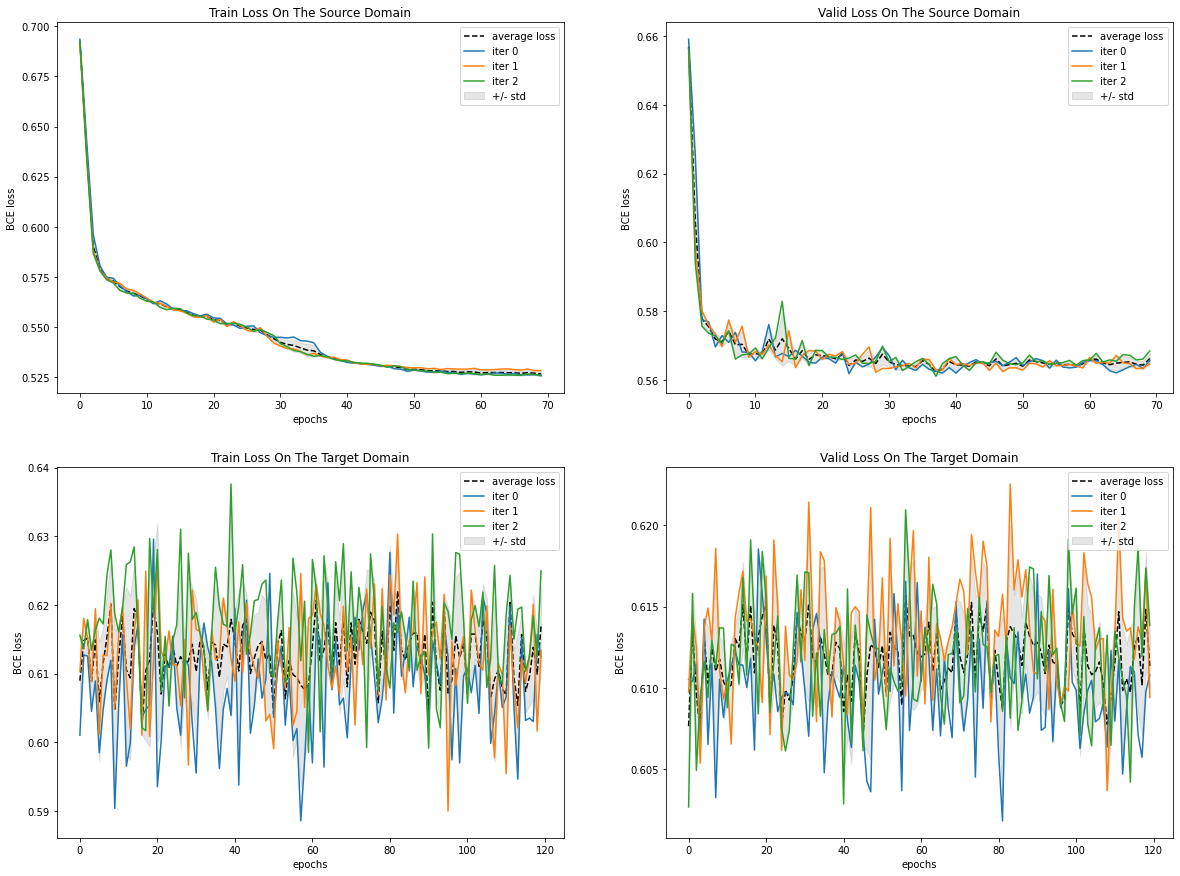

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

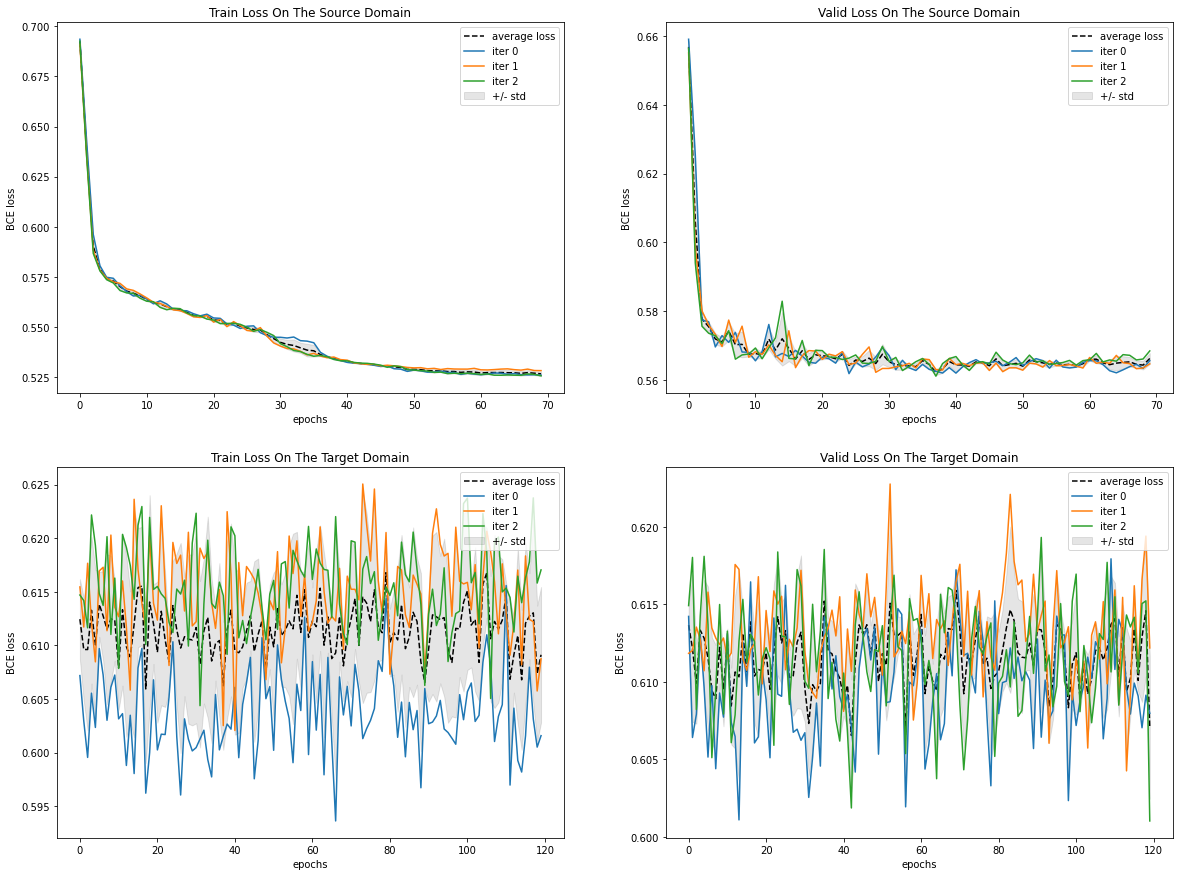

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

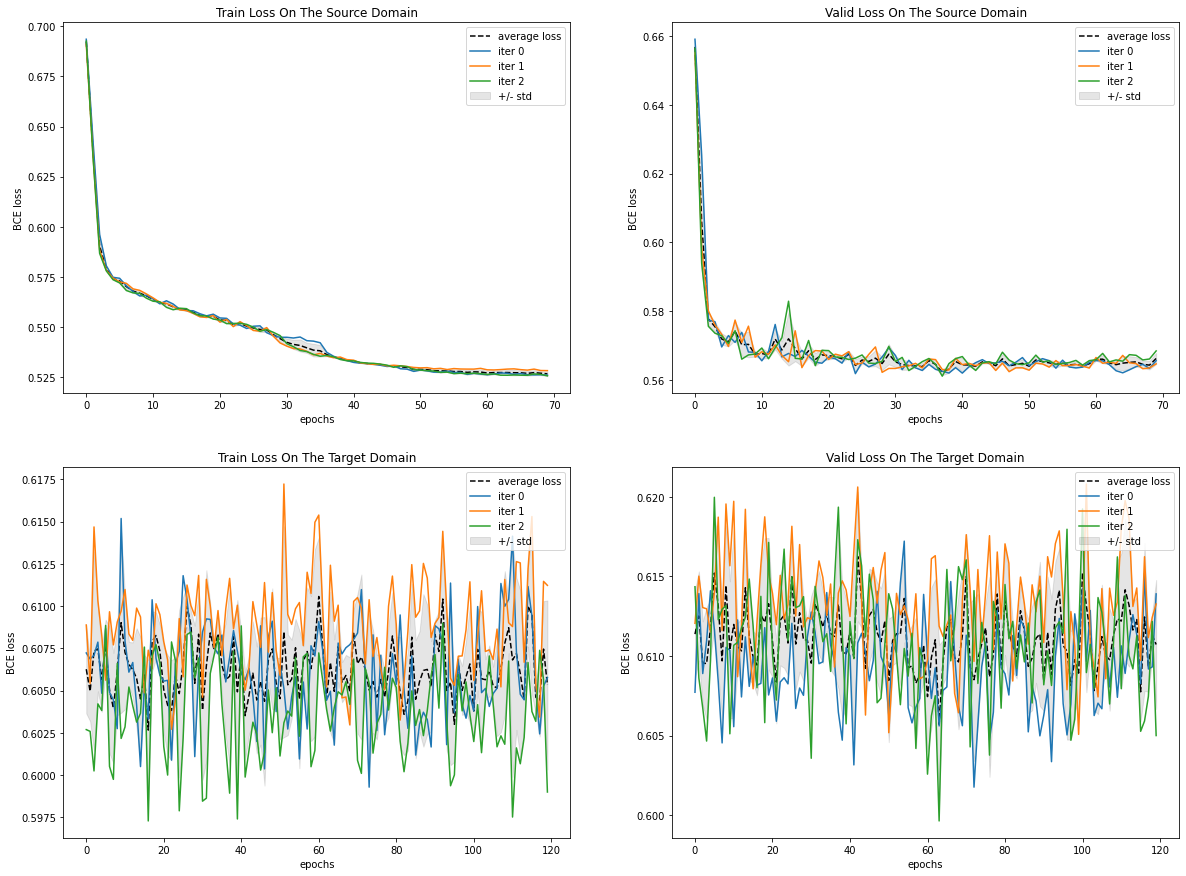

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

# Visualize training and validation accuracies for the two training phases

In [27]:
def plot_accuracies(df, phase='target', n_target_samples=20, acc_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{acc_type}_acc'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    acc = np.stack(stackable)

    avg_acc = np.mean(acc, axis=0)
    upper_ = avg_acc + np.std(acc, axis=0)
    lower_ = avg_acc - np.std(acc, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_acc, 'k--')
    ax.plot(acc.T)
    ax.legend(['average accuracy', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='lower right')

    ax.set_title(f'{acc_type} Accuracy on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('Accuracy')


## 20 MIMIC samples

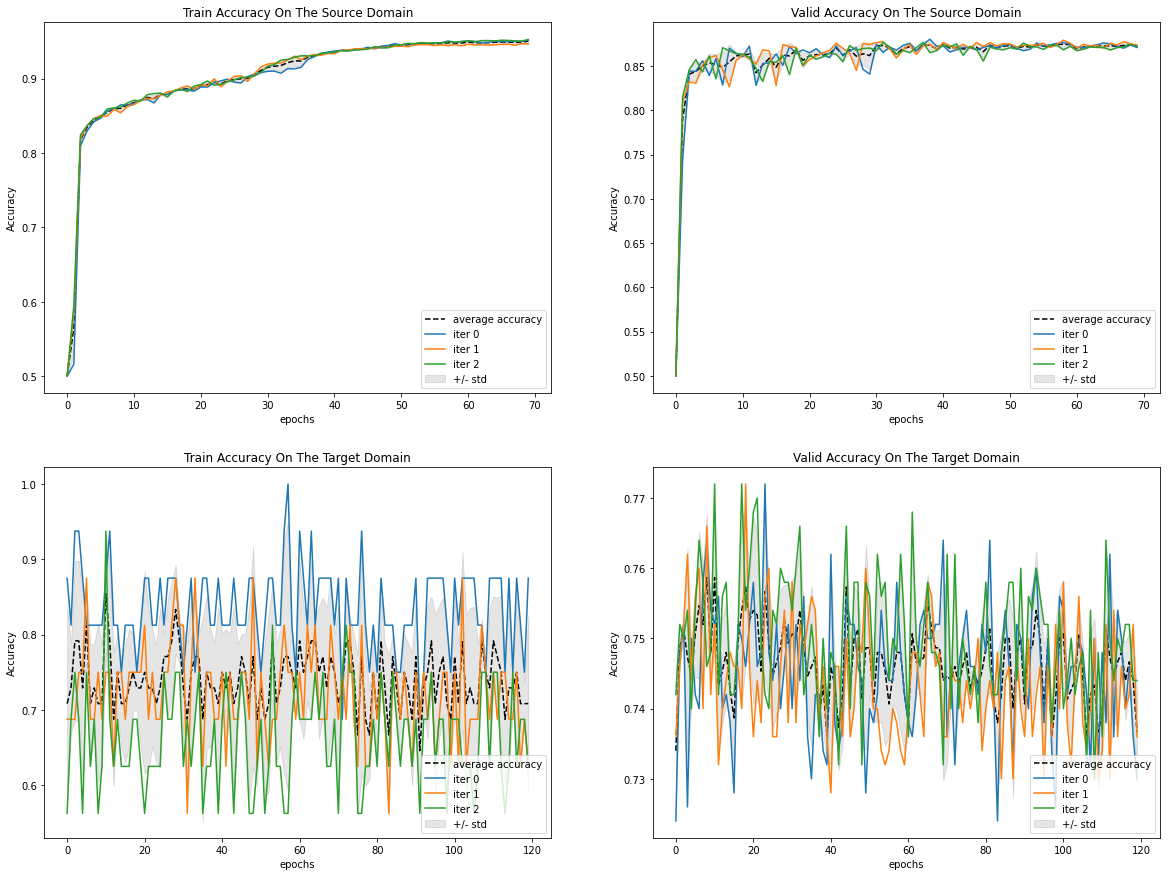

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

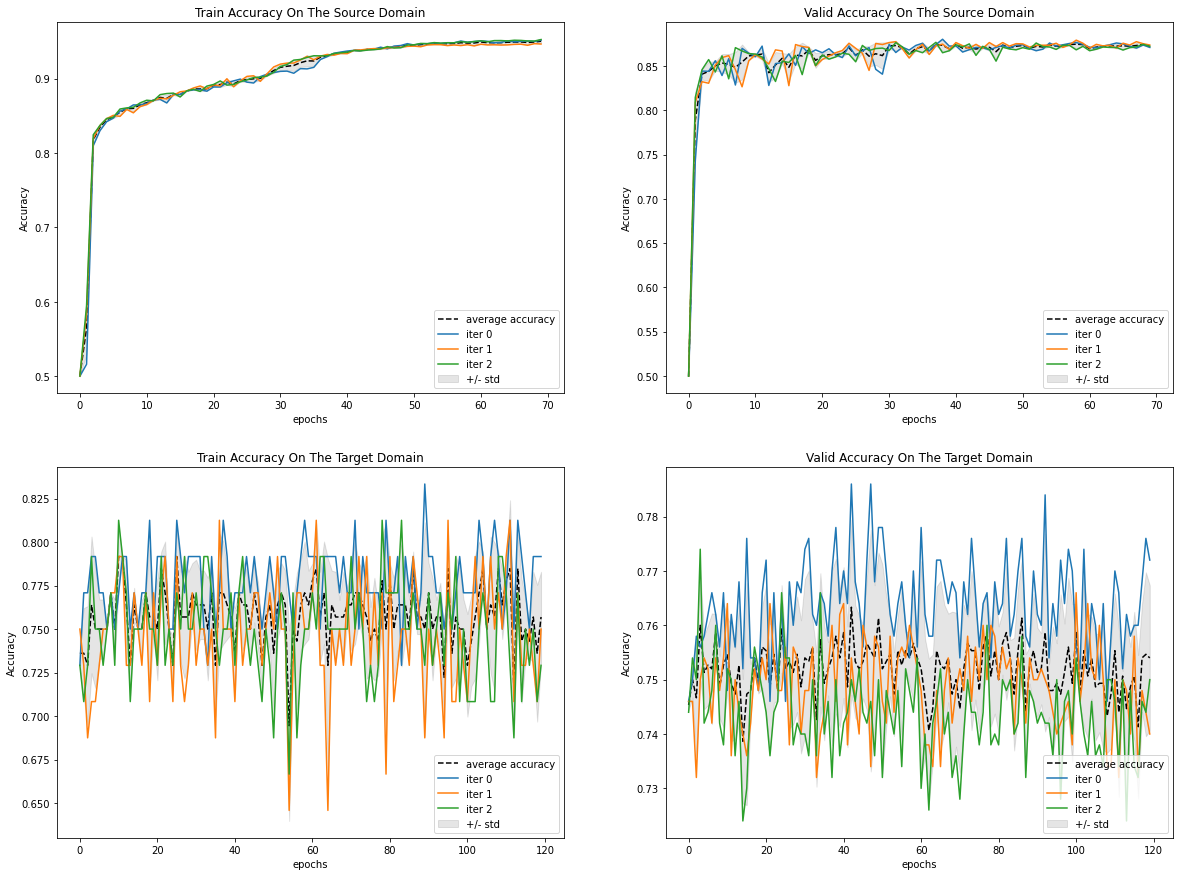

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

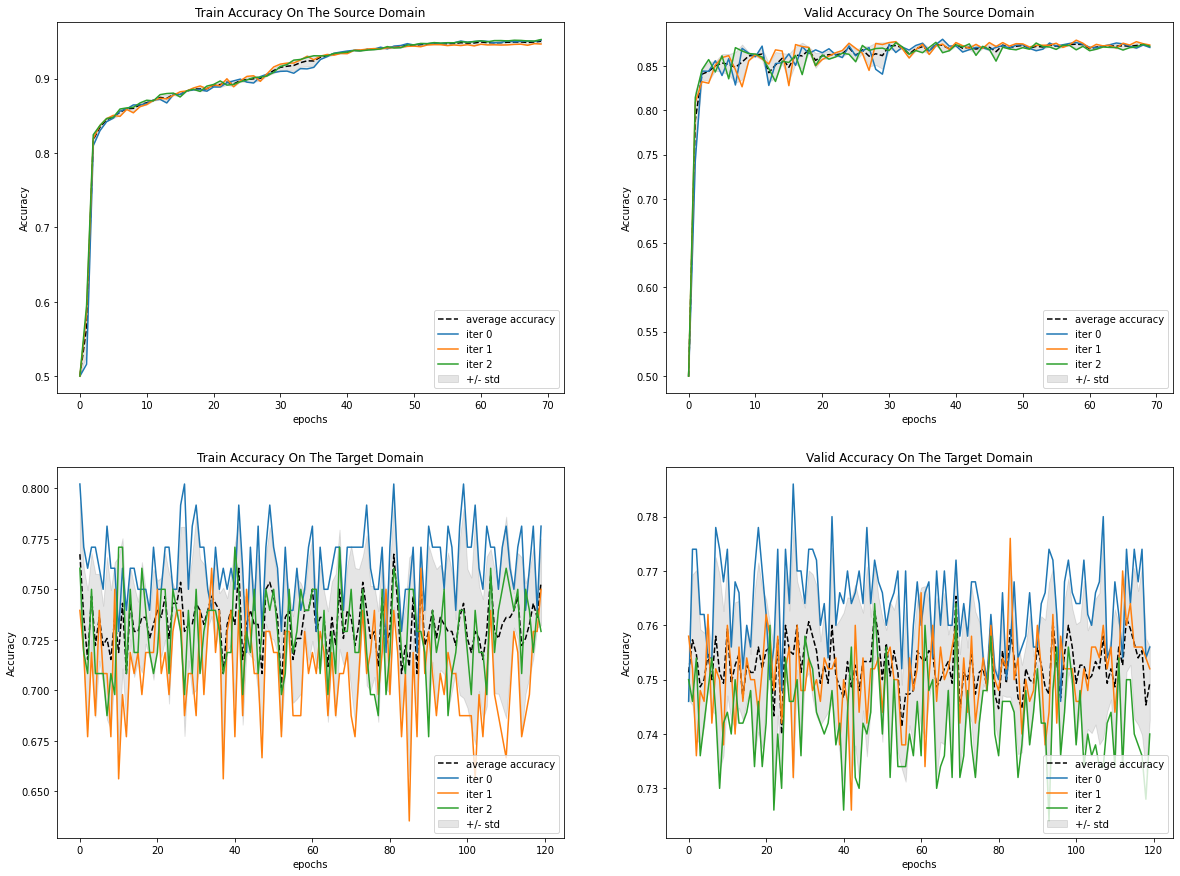

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

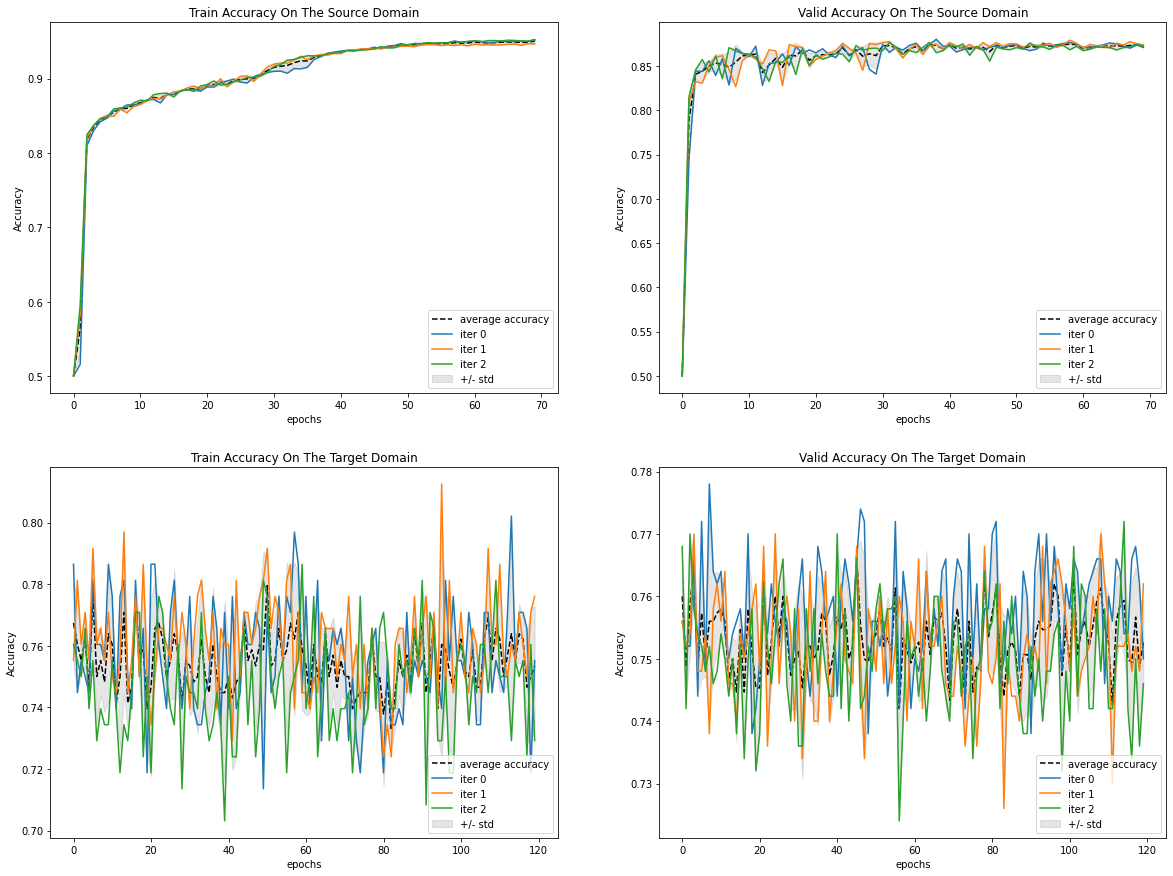

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

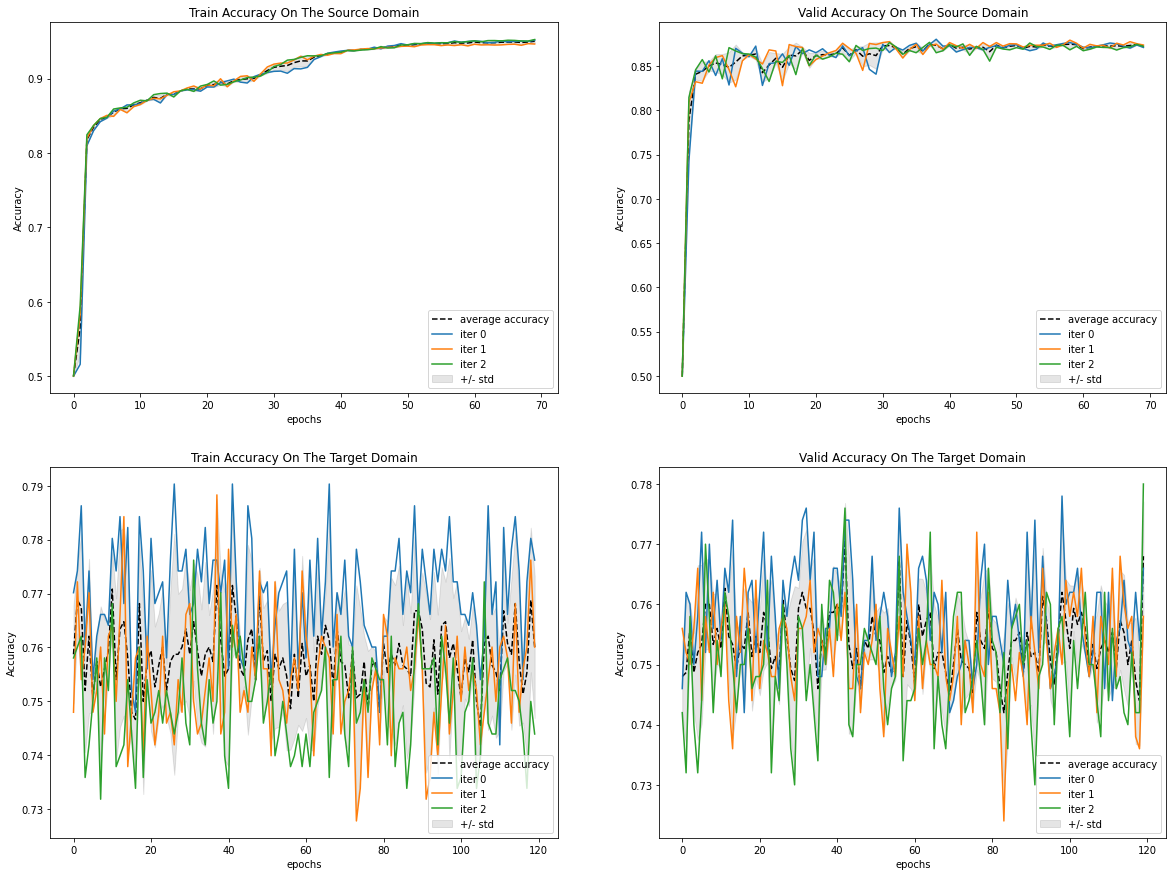

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

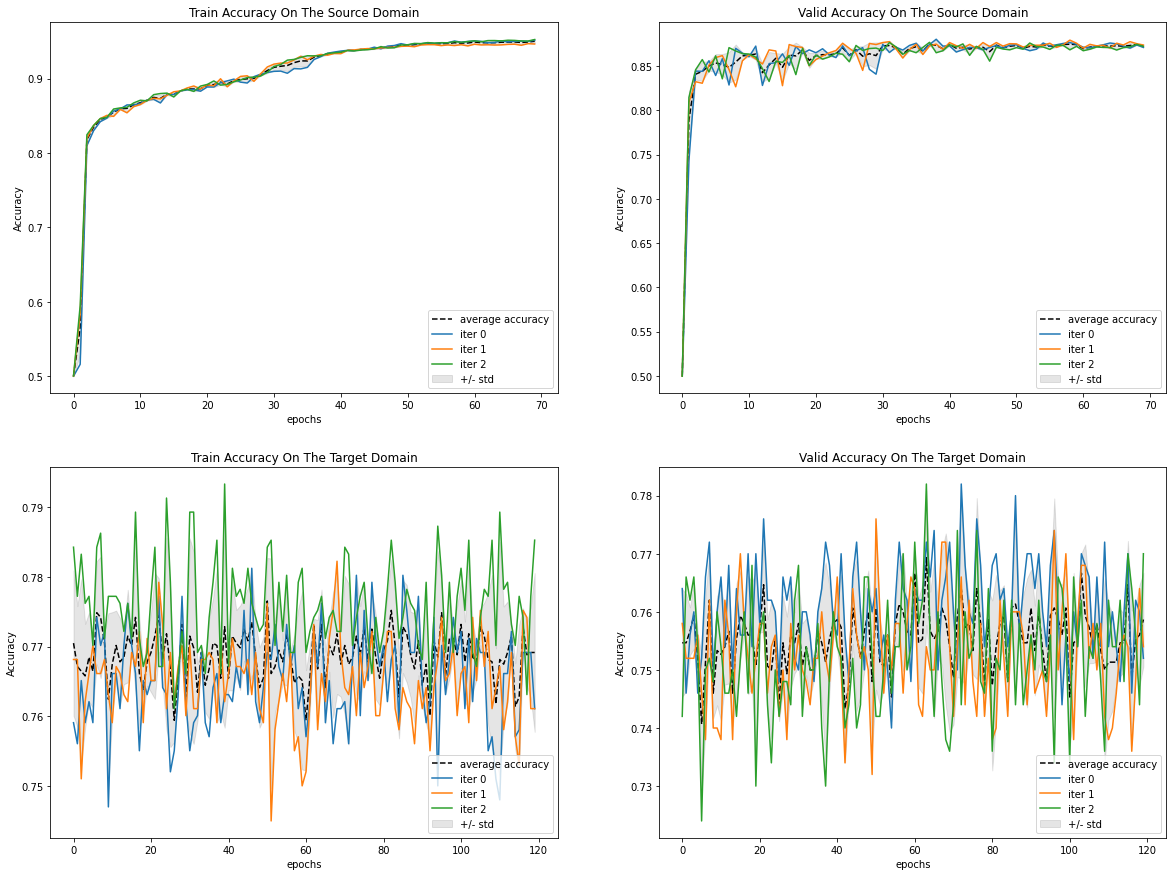

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

# Summarize training metrics for trained models

In [38]:
target_meta = model_meta[model_meta['phase'] == 'target']

training_cols = ['final_train_loss', 'final_valid_loss', 'best_valid_loss', 'final_valid_acc', 'best_valid_acc',
                 'mimic_best_test_acc', 'mimic_final_test_acc', 'chexpert_best_test_acc', 'chexpert_final_test_acc']

In [39]:
target_meta.groupby('n_target_samples').mean(numeric_only=True)[training_cols]

final_train_loss  final_valid_loss  best_valid_loss  \
n_target_samples                                                        
20                        0.621004          0.616951         0.603683   
50                        0.612713          0.611626         0.602571   
100                       0.613499          0.612324         0.603021   
200                       0.616926          0.611354         0.602744   
500                       0.609125          0.607056         0.602119   
1000                      0.605329          0.610725         0.602154   

                  final_valid_acc  best_valid_acc  mimic_best_test_acc  \
n_target_samples                                                         
20                       0.736667        0.772000             0.763642   
50                       0.754000        0.775333             0.765898   
100                      0.749333        0.775333             0.768906   
200                      0.752667        0.773333             0.774045   
500                      0.768000        0.776667             0.770995   
1000                     0.758667        0.780000             0.772583   

                  mimic_final_test_acc  chexpert_best_test_acc  \
n_target_samples                                                 
20                            0.763266                0.803458   
50                            0.765229                0.802417   
100                           0.768823                0.813333   
200                           0.770536                0.828625   
500                           0.770285                0.817542   
1000                          0.770870                0.822542   

                  chexpert_final_test_acc  
n_target_samples                           
20                               0.796375  
50                               0.801583  
100                              0.811375  
200                              0.816292  
500                              0.814958  
1000                             0.817750